<a href="https://colab.research.google.com/github/jettecampbell/data-science/blob/main/JettCampU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How Much are Soccer Player's Paid Across Different Leagues?

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import pandas as pd

## Setting up the Data

In this project, I want to determine the relationship between a soccer player's yearly wage and the league they play for. The dataset I'm using consists of every soccer player in all the major leagues around the world, and each of their major indentifying information like wage, age, club, etc.

In [3]:
#raw csv soccer data
path = 'https://raw.githubusercontent.com/jettecampbell/data-science/refs/heads/main/SalaryPrediction.csv'

In [4]:
#turns the league column into a categorical varliable
data = pd.read_csv(path,dtype={'League':'category'})

In [5]:
#displays full data table
data

,Wage,Age,Club,League,Nation,Position,Apps,Caps
0,"46,427,000",23,PSG,Ligue 1 Uber Eats,FRA,Forward,190,57
1,"42,125,000",30,PSG,Ligue 1 Uber Eats,BRA,Midfilder,324,119
2,"34,821,000",35,PSG,Ligue 1 Uber Eats,ARG,Forward,585,162
3,"19,959,000",31,R. Madrid,La Liga,BEL,Forward,443,120
4,"19,500,000",31,Man UFC,Premier League,ESP,Goalkeeper,480,45
...,...,...,...,...,...,...,...,...
3902,"3,400",19,Vigo,La Liga,ESP,Defender,0,0
3903,"3,200",18,Famalicao,Primiera Liga,BRA,Goalkeeper,0,0
3904,"2,900",18,Vigo,La Liga,ESP,Forward,0,0
3905,"2,700",18,Vigo,La Liga,ESP,Defender,0,0


First I tried creating a violon plot of the wage data in order to get a rough idea of the distribution, but I realized the wages were listed as strings. This made me unable to use them as continuous variables, creating the very unhelpful plot seen below.

<Axes: ylabel='Wage'>

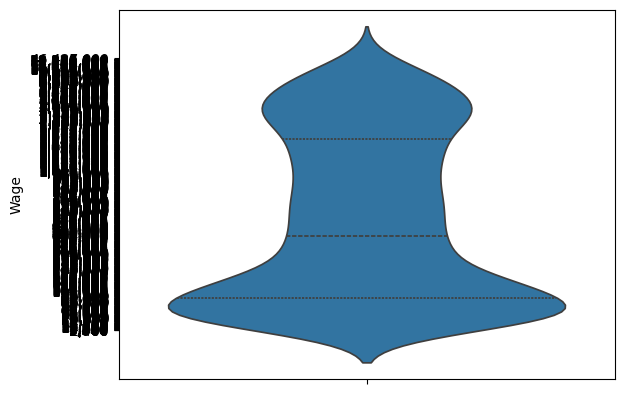

In [6]:
#plotting data
sns.violinplot(data.Wage,inner='quart')

To fix this, I used a for loop to parse through the entire data frame and copy the wages as integers into a new data frame. The wages also contained commas, so I had to remove them from each value. This new data frame consisted only the player wages and league which are the categories I will be using to plot.

In [7]:
#creates new empty data frame with the categories I need
new_data = pd.DataFrame(columns = ['wage', 'league'])
index = 0 #keep track of where I am in the dataframe
for x in data.Wage: #goes through each wage in my data
  new_wage = int(data.Wage[index].replace(',','')) #creates a new integer wage from each string wage
  new_data.loc[len(new_data.index)] = [new_wage, data.League[index]] #adds wage and league to new dataframe
  index += 1
  #if index > 999:
  #  break

In [8]:
#displays new table
new_data

,wage,league
0,46427000,Ligue 1 Uber Eats
1,42125000,Ligue 1 Uber Eats
2,34821000,Ligue 1 Uber Eats
3,19959000,La Liga
4,19500000,Premier League
...,...,...
3902,3400,La Liga
3903,3200,Primiera Liga
3904,2900,La Liga
3905,2700,La Liga


This new data was able to be displayed in a violin plot. The data shows a heavy postive skew.

<Axes: ylabel='wage'>

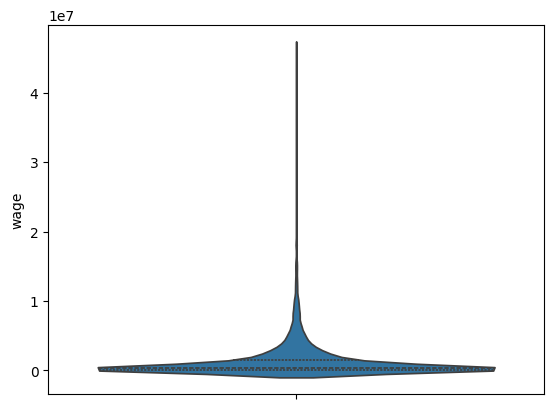

In [9]:
#plotting data
sns.violinplot(new_data.wage,inner='quart')

## Creating a Predictive Model

In [10]:
#turns the league column into a categorical variable
new_data['league'] = pd.Categorical(new_data.league)

#this is an array of the soccer leagues
leag_idx = new_data.league.cat.codes.values

#an array of the strings that represent league
leag_codes = new_data.league.cat.categories

#puts coords in a dict, so pymc can read them
leag_coords = {"league": leag_codes}

In [11]:
#integer codes for each of the leagues
leag_idx

array([2, 2, 2, ..., 1, 1, 1], dtype=int8)

In [12]:
#list of leagues
leag_coords

{'league': Index(['Bundesliga', 'La Liga', 'Ligue 1 Uber Eats', 'Premier League',
        'Primiera Liga', 'Serie A'],
       dtype='object')}

I began with a normal model to predict the wages just to see how it would fit the data. This model outputted multiple warnings and the posterior predictive mean ended up being way off from the observed. I decided I needed to use a model with a higher postive skew.

In [14]:
with pm.Model(coords=leag_coords) as sccr_model:
    #hyperpriors
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd)

    σ = pm.HalfNormal('σ', sigma = 10)

    #normal likelihood
    y = pm.Normal('league',
                  mu = μ,
                  sigma = σ,
                  observed = new_data.wage)

    #a very high target acceptance to limit divergences
    idata_sccr = pm.sample(target_accept = 0.98)

Output()

Output()

Output()

<Axes: xlabel='league'>

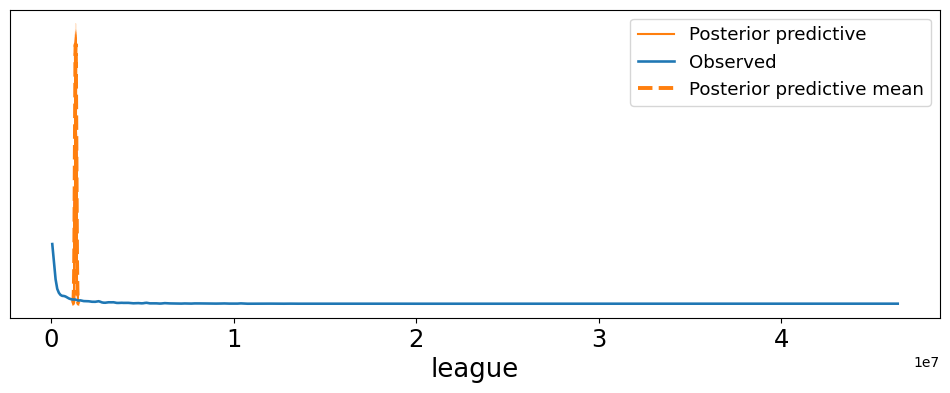

In [15]:
pm.sample_posterior_predictive(idata_sccr, model=sccr_model, extend_inferencedata=True)
az.plot_ppc(idata_sccr, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Here I use a exponetial model because it closely matches the distribution of the observed data. I noticed I required a very high lambda value to match, so with my Gamma hypepriors, I plugged in very extreme values. This posterior predictive mean fit the observed much better.

In [16]:
with pm.Model(coords = leag_coords) as sccr_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 500000, beta = 100)
    b = pm.Gamma('b', alpha = 100, beta = 500000)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b)

    #exponential likelihood
    _ = pm.Exponential('league', lam = λ, observed = new_data.wage)

    #a very high target acceptance to limit divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

<Axes: xlabel='league'>

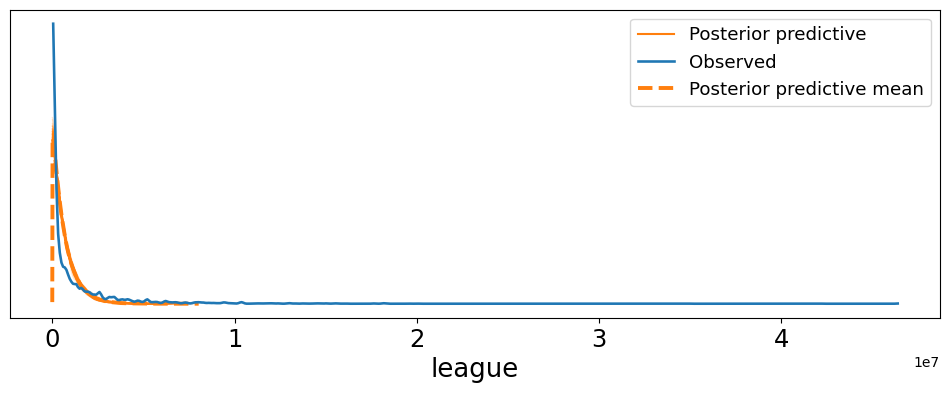

In [17]:
pm.sample_posterior_predictive(idata_sccr, model=sccr_model, extend_inferencedata=True)
az.plot_ppc(idata_sccr, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

With a model that matched, I could now use the hierarchal model to compare the wages to the league categories.

In [18]:
with pm.Model(coords = leag_coords) as sccr_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 500000, beta = 100)
    b = pm.Gamma('b', alpha = 100, beta = 500000)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b, dims = "league")

    #exponential likelihood
    _ = pm.Exponential('league', lam = λ[leag_idx], observed = new_data.wage)

    #a very high target acceptance to limit divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

## Analyzing the Model

After tracing the models, we can see the distributions match up with the data very well. There are obvious peaks for each of the leagues with one outlier. In addition, the rhat values are close to ideal (between 1 and 1.001) as none of them exceed 1.1.

<xarray.Dataset> Size: 472B
Dimensions:  (league: 6)
Coordinates:
  * league   (league) <U17 408B 'Bundesliga' 'La Liga' ... 'Serie A'
Data variables:
    a        float64 8B 1.0
    b        float64 8B 1.0
    λ        (league) float64 48B 1.005 1.0 1.003 1.002 0.9998 1.001

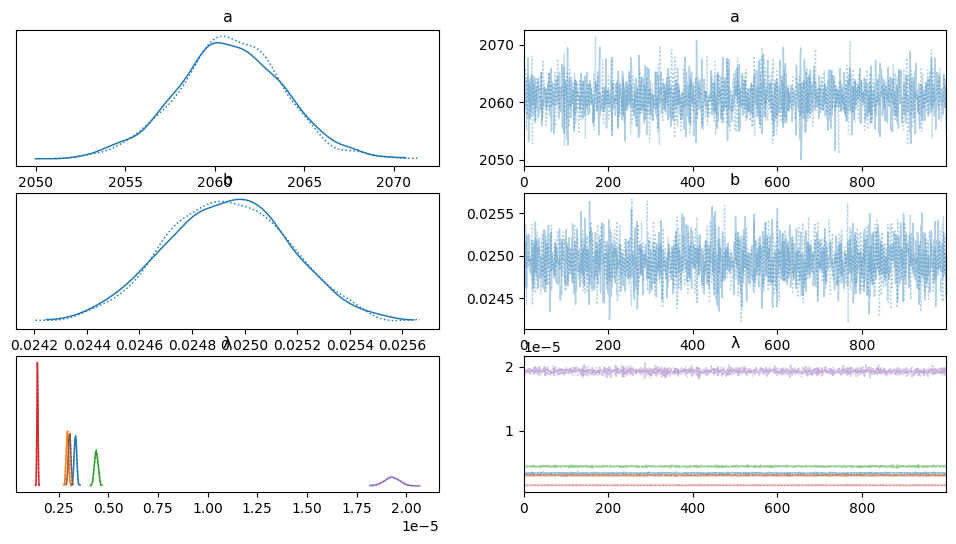

In [19]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

Plotting the models into forest plots, we get very smoothly formed distributions with apparent centers. However, these plot the λ values of each league meaning we'll have to take their reciprocals to interpret the data.

array([<Axes: >], dtype=object)

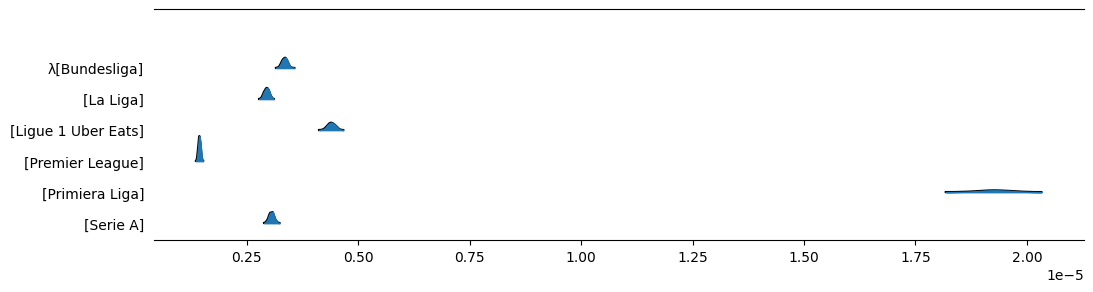

In [20]:
az.plot_forest(idata_sccr, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998, markersize = 0.1)

There is probably a more accurate way to calculate these values, but I guessed where the mean λ value for each distribution was and took their reciprocals. This gives me rough guesses as to what the average wages for each major soccer league is.

In [21]:
print(f'Bundesliga: {1/(0.33*0.00001)}')
print(f'La Liga: {1/(0.29*0.00001)}')
print(f'Ligue 1 Uber Eats: {1/(0.42*0.00001)}')
print(f'Premier League: {1/(0.13*0.00001)}')
print(f'Primiera Liga: {1/(1.9*0.00001)}')
print(f'Serie A: {1/(0.31*0.00001)}')

Bundesliga: 303030.303030303
La Liga: 344827.5862068965
Ligue 1 Uber Eats: 238095.23809523808
Premier League: 769230.7692307692
Primiera Liga: 52631.57894736842
Serie A: 322580.6451612903


From these values we can conclude Premier League on average pays their players the most with high certainty at around 770k a year. I expected this result because I believe Premier League is the most well known of the major leagues with the most star players. On the other hand, Primiera Liga pays the least at around 53k a year also with a high certainty. The other 4 major leagues are all centered very close to eachother raning from about 200k-350k. None of these results suprised me much except for how low Primiera Liga's average wage was, but then again I have never heard of a player that plays there.